In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/Solor_Panels_Segmentation/model_development_dataset /content/pvdata
print("✅ copied to /content/pvdata")

KeyboardInterrupt: 

In [ ]:
# 设置数据与输出目录
DATA_ROOT = '/content/pvdata'   # 你已经复制好的本地路径
RESULT_DIR = '/content/drive/MyDrive/results'

import os
os.makedirs(RESULT_DIR, exist_ok=True)

print("✅ 数据路径:", DATA_ROOT)
print("✅ 结果路径:", RESULT_DIR)

✅ 数据路径: /content/pvdata
✅ 结果路径: /content/drive/MyDrive/results


In [ ]:
# ==========================
# 数据集定义与 DataLoader 优化
# ==========================
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class SolarSegDataset(Dataset):
    def __init__(self, txt_path, root_dir, phase='train', img_size=(256, 256)):
        self.root_dir = root_dir
        self.phase = phase
        self.img_size = img_size
        with open(txt_path, 'r') as f:
            self.ids = [line.strip() for line in f.readlines() if line.strip()]
        self.img_dir = os.path.join(root_dir, phase, 'img')
        self.mask_dir = os.path.join(root_dir, phase, 'mask')
        self.train_tf = T.Compose([
            T.Resize(img_size),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2),
            T.ToTensor(),
        ])
        self.val_tf = T.Compose([
            T.Resize(img_size),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        img = Image.open(os.path.join(self.img_dir, id_ + '.png')).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, id_ + '.png'))
        img = self.train_tf(img) if self.phase == 'train' else self.val_tf(img)
        mask = mask.resize(self.img_size, resample=Image.NEAREST)
        mask = (np.array(mask) > 0).astype(np.int64)
        return img, torch.from_numpy(mask)

TRAIN_TXT = os.path.join(DATA_ROOT, 'train.txt')
VAL_TXT   = os.path.join(DATA_ROOT, 'val.txt')

train_dataset = SolarSegDataset(TRAIN_TXT, DATA_ROOT, 'train')
val_dataset   = SolarSegDataset(VAL_TXT, DATA_ROOT, 'val')
print(f"✅ train: {len(train_dataset)}, val: {len(val_dataset)}")


✅ train: 6415, val: 1604


In [ ]:
# ==========================
# 模型与 Batch Size 自动检测
# ==========================
import torchvision
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
print("✅ 使用设备:", device, torch.cuda.get_device_name(0) if device=='cuda' else '')

model = torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT')
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from torch.utils.data import DataLoader

def find_max_batch(model, dataset, device="cuda", start_bs=12):
    bs = start_bs
    while bs >= 1:
        try:
            loader = DataLoader(dataset, batch_size=bs, num_workers=2, pin_memory=True)
            imgs, masks = next(iter(loader))
            imgs, masks = imgs.to(device), masks.to(device)
            with torch.cuda.amp.autocast():
                _ = model(imgs)['out']
            torch.cuda.empty_cache()
            print(f"✅ batch_size={bs} OK")
            return bs
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"⚠️ batch_size={bs} OOM, try smaller...")
                torch.cuda.empty_cache()
                bs //= 2
            else:
                raise e
    return 1

best_bs = find_max_batch(model, train_dataset, device=device)
print("👉 最佳 batch_size:", best_bs)

train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True,
                          num_workers=2, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=best_bs, shuffle=False,
                          num_workers=2, pin_memory=True, persistent_workers=True)


✅ 使用设备: cuda Tesla T4


/tmp/ipython-input-4170097326.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


✅ batch_size=12 OK
👉 最佳 batch_size: 12


In [ ]:
# ==========================
# Week 5 训练循环
# ==========================
from tqdm import tqdm
import json, numpy as np

def compute_iou(pred, target, num_classes=2):
    ious=[]
    for c in range(num_classes):
        p, t = (pred==c), (target==c)
        inter, union = (p&t).sum().item(), (p|t).sum().item()
        ious.append(1.0 if union==0 else inter/union)
    return float(np.mean(ious))

def prf1(pred, target):
    pred, target = pred.reshape(-1), target.reshape(-1)
    tp = ((pred==1)&(target==1)).sum().item()
    fp = ((pred==1)&(target==0)).sum().item()
    fn = ((pred==0)&(target==1)).sum().item()
    p = tp/(tp+fp+1e-8); r = tp/(tp+fn+1e-8)
    return p, r, 2*p*r/(p+r+1e-8)

MAX_EPOCHS, PATIENCE = 80, 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
best_miou, no_improve, history = 0, 0, {}
scaler = torch.cuda.amp.GradScaler()

for epoch in range(MAX_EPOCHS):
    model.train(); run_loss=0
    for imgs, masks in tqdm(train_loader, desc=f"[{epoch+1}/{MAX_EPOCHS}] train"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs)['out']
            loss = criterion(out, masks)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        run_loss += loss.item()*imgs.size(0)
    train_loss = run_loss/len(train_dataset)

    # ---- validation ----
    model.eval(); val_loss=0; ious=[]; ps=[]; rs=[]; fs=[]
    with torch.no_grad():
        for imgs,masks in tqdm(val_loader, desc=f"[{epoch+1}/{MAX_EPOCHS}] val"):
            imgs,masks = imgs.to(device), masks.to(device)
            with torch.cuda.amp.autocast():
                out = model(imgs)['out']; loss = criterion(out, masks)
            val_loss += loss.item()*imgs.size(0)
            pred = out.argmax(1)
            ious.append(compute_iou(pred.cpu(), masks.cpu()))
            p,r,f = prf1((pred.cpu()>0).long(), (masks.cpu()>0).long())
            ps.append(p); rs.append(r); fs.append(f)

    val_loss/=len(val_dataset); miou, P,R,F = map(float,[np.mean(ious),np.mean(ps),np.mean(rs),np.mean(fs)])
    print(f"Epoch {epoch+1:02d}: loss={val_loss:.4f}, mIoU={miou:.4f}, F1={F:.4f}")

    if miou>best_miou:
        best_miou, no_improve = miou, 0
        torch.save(model.state_dict(), f"{RESULT_DIR}/deeplabv3_best_{miou:.4f}_ep{epoch+1}.pth")
    else:
        no_improve += 1
    scheduler.step()
    if no_improve>=PATIENCE:
        print(f"⛔ Early Stop at {epoch+1}, best mIoU={best_miou:.4f}")
        break


/tmp/ipython-input-457240332.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
[1/80] train:   0%|          | 0/535 [00:00<?, ?it/s]/tmp/ipython-input-457240332.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[1/80] val:   0%|          | 0/134 [00:00<?, ?it/s]/tmp/ipython-input-457240332.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[1/80] val: 100%|██████████| 134/134 [00:16<00:00,  8.06it/s]


Epoch 01: loss=0.0318, mIoU=0.8229, F1=0.7874


[2/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.80it/s]


Epoch 02: loss=0.0158, mIoU=0.8770, F1=0.8613


[3/80] val: 100%|██████████| 134/134 [00:16<00:00,  8.36it/s]


Epoch 03: loss=0.0097, mIoU=0.9042, F1=0.8951


[4/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.67it/s]


Epoch 04: loss=0.0078, mIoU=0.9150, F1=0.9080


[5/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.57it/s]


Epoch 05: loss=0.0072, mIoU=0.9091, F1=0.9003


[6/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.68it/s]


Epoch 06: loss=0.0062, mIoU=0.9274, F1=0.9226


[7/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.67it/s]


Epoch 07: loss=0.0064, mIoU=0.9236, F1=0.9179


[8/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.62it/s]


Epoch 08: loss=0.0053, mIoU=0.9333, F1=0.9293


[9/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.60it/s]


Epoch 09: loss=0.0067, mIoU=0.9214, F1=0.9150


[10/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.48it/s]


Epoch 10: loss=0.0048, mIoU=0.9381, F1=0.9347


[11/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.72it/s]


Epoch 11: loss=0.0048, mIoU=0.9374, F1=0.9339


[12/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.73it/s]


Epoch 12: loss=0.0053, mIoU=0.9400, F1=0.9356


[13/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.58it/s]


Epoch 13: loss=0.0062, mIoU=0.9325, F1=0.9268


[14/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.56it/s]


Epoch 14: loss=0.0054, mIoU=0.9392, F1=0.9348


[15/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.59it/s]


Epoch 15: loss=0.0053, mIoU=0.9389, F1=0.9346


[16/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.63it/s]


Epoch 16: loss=0.0039, mIoU=0.9473, F1=0.9450


[17/80] val: 100%|██████████| 134/134 [00:16<00:00,  8.34it/s]


Epoch 17: loss=0.0041, mIoU=0.9468, F1=0.9444


[18/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.51it/s]


Epoch 18: loss=0.0047, mIoU=0.9457, F1=0.9426


[19/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.61it/s]


Epoch 19: loss=0.0041, mIoU=0.9467, F1=0.9444


[20/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.76it/s]


Epoch 20: loss=0.0041, mIoU=0.9478, F1=0.9456


[21/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.75it/s]


Epoch 21: loss=0.0040, mIoU=0.9488, F1=0.9466


[22/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.74it/s]


Epoch 22: loss=0.0041, mIoU=0.9485, F1=0.9464


[23/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.70it/s]


Epoch 23: loss=0.0040, mIoU=0.9487, F1=0.9466


[24/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.73it/s]


Epoch 24: loss=0.0042, mIoU=0.9473, F1=0.9451


[25/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.77it/s]


Epoch 25: loss=0.0040, mIoU=0.9488, F1=0.9466


[26/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.73it/s]


Epoch 26: loss=0.0042, mIoU=0.9479, F1=0.9457


[27/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.76it/s]


Epoch 27: loss=0.0043, mIoU=0.9479, F1=0.9457


[28/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.68it/s]


Epoch 28: loss=0.0042, mIoU=0.9491, F1=0.9470


[29/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.75it/s]


Epoch 29: loss=0.0043, mIoU=0.9474, F1=0.9451


[30/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.85it/s]


Epoch 30: loss=0.0043, mIoU=0.9491, F1=0.9470


[31/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.80it/s]


Epoch 31: loss=0.0042, mIoU=0.9503, F1=0.9483


[32/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.88it/s]


Epoch 32: loss=0.0042, mIoU=0.9503, F1=0.9483


[33/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.75it/s]


Epoch 33: loss=0.0043, mIoU=0.9504, F1=0.9484


[34/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.80it/s]


Epoch 34: loss=0.0043, mIoU=0.9500, F1=0.9480


[35/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.88it/s]


Epoch 35: loss=0.0045, mIoU=0.9499, F1=0.9478


[36/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.71it/s]


Epoch 36: loss=0.0045, mIoU=0.9499, F1=0.9478


[37/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.70it/s]


Epoch 37: loss=0.0046, mIoU=0.9498, F1=0.9478


[38/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.53it/s]


Epoch 38: loss=0.0045, mIoU=0.9500, F1=0.9480


[39/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.73it/s]


Epoch 39: loss=0.0047, mIoU=0.9496, F1=0.9476


[40/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.79it/s]


Epoch 40: loss=0.0048, mIoU=0.9499, F1=0.9478


[41/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.82it/s]


Epoch 41: loss=0.0049, mIoU=0.9495, F1=0.9474


[42/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.87it/s]


Epoch 42: loss=0.0049, mIoU=0.9496, F1=0.9475


[43/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.84it/s]

Epoch 43: loss=0.0049, mIoU=0.9497, F1=0.9477
⛔ Early Stop at 43, best mIoU=0.9504


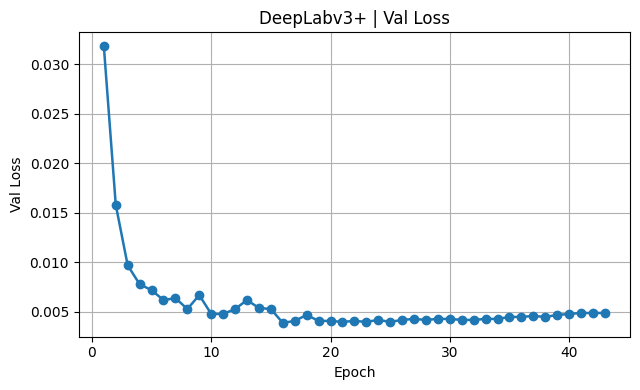

✅ Saved: /content/drive/MyDrive/results/week5_val_loss.png


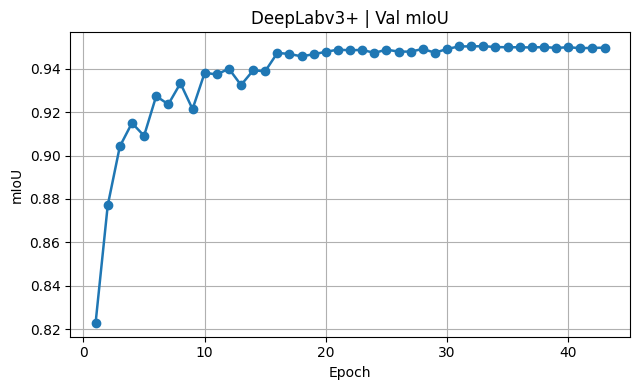

✅ Saved: /content/drive/MyDrive/results/week5_val_miou.png


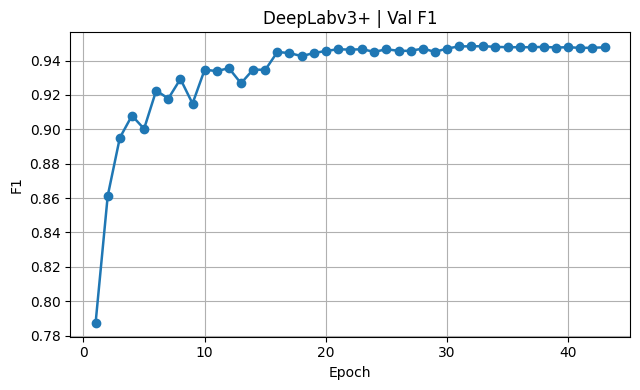

✅ Saved: /content/drive/MyDrive/results/week5_val_f1.png
⭐ Best mIoU = 0.9504 @ epoch 33
ℹ️ Epochs parsed: 43 | FIRST=1 LAST=43


In [ ]:
# === 1) 把你训练时打印的日志粘贴到 raw 里 ===
raw = r"""
/tmp/ipython-input-457240332.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
[1/80] train:   0%|          | 0/535 [00:00<?, ?it/s]/tmp/ipython-input-457240332.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[1/80] train: 100%|██████████| 535/535 [02:13<00:00,  4.01it/s]
[1/80] val:   0%|          | 0/134 [00:00<?, ?it/s]/tmp/ipython-input-457240332.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
[1/80] val: 100%|██████████| 134/134 [00:16<00:00,  8.06it/s]
Epoch 01: loss=0.0318, mIoU=0.8229, F1=0.7874
[2/80] train: 100%|██████████| 535/535 [02:03<00:00,  4.32it/s]
[2/80] val: 100%|██████████| 134/134 [00:15<00:00,  8.80it/s]
Epoch 02: loss=0.0158, mIoU=0.8770, F1=0.8613
[3/80] train: 100%|██████████| 535/535 [02:03<00:00,  4.34it/s]
[3/80] val: 100%|██████████| 134/134 [00:16<00:00,  8.36it/s]
Epoch 03: loss=0.0097, mIoU=0.9042, F1=0.8951
Epoch 04: loss=0.0078, mIoU=0.9150, F1=0.9080
Epoch 05: loss=0.0072, mIoU=0.9091, F1=0.9003
Epoch 06: loss=0.0062, mIoU=0.9274, F1=0.9226
Epoch 07: loss=0.0064, mIoU=0.9236, F1=0.9179
Epoch 08: loss=0.0053, mIoU=0.9333, F1=0.9293
Epoch 09: loss=0.0067, mIoU=0.9214, F1=0.9150
Epoch 10: loss=0.0048, mIoU=0.9381, F1=0.9347
Epoch 11: loss=0.0048, mIoU=0.9374, F1=0.9339
Epoch 12: loss=0.0053, mIoU=0.9400, F1=0.9356
Epoch 13: loss=0.0062, mIoU=0.9325, F1=0.9268
Epoch 14: loss=0.0054, mIoU=0.9392, F1=0.9348
Epoch 15: loss=0.0053, mIoU=0.9389, F1=0.9346
Epoch 16: loss=0.0039, mIoU=0.9473, F1=0.9450
Epoch 17: loss=0.0041, mIoU=0.9468, F1=0.9444
Epoch 18: loss=0.0047, mIoU=0.9457, F1=0.9426
Epoch 19: loss=0.0041, mIoU=0.9467, F1=0.9444
Epoch 20: loss=0.0041, mIoU=0.9478, F1=0.9456
Epoch 21: loss=0.0040, mIoU=0.9488, F1=0.9466
Epoch 22: loss=0.0041, mIoU=0.9485, F1=0.9464
Epoch 23: loss=0.0040, mIoU=0.9487, F1=0.9466
Epoch 24: loss=0.0042, mIoU=0.9473, F1=0.9451
Epoch 25: loss=0.0040, mIoU=0.9488, F1=0.9466
Epoch 26: loss=0.0042, mIoU=0.9479, F1=0.9457
Epoch 27: loss=0.0043, mIoU=0.9479, F1=0.9457
Epoch 28: loss=0.0042, mIoU=0.9491, F1=0.9470
Epoch 29: loss=0.0043, mIoU=0.9474, F1=0.9451
Epoch 30: loss=0.0043, mIoU=0.9491, F1=0.9470
Epoch 31: loss=0.0042, mIoU=0.9503, F1=0.9483
Epoch 32: loss=0.0042, mIoU=0.9503, F1=0.9483
Epoch 33: loss=0.0043, mIoU=0.9504, F1=0.9484
Epoch 34: loss=0.0043, mIoU=0.9500, F1=0.9480
Epoch 35: loss=0.0045, mIoU=0.9499, F1=0.9478
Epoch 36: loss=0.0045, mIoU=0.9499, F1=0.9478
Epoch 37: loss=0.0046, mIoU=0.9498, F1=0.9478
Epoch 38: loss=0.0045, mIoU=0.9500, F1=0.9480
Epoch 39: loss=0.0047, mIoU=0.9496, F1=0.9476
Epoch 40: loss=0.0048, mIoU=0.9499, F1=0.9478
Epoch 41: loss=0.0049, mIoU=0.9495, F1=0.9474
Epoch 42: loss=0.0049, mIoU=0.9496, F1=0.9475
Epoch 43: loss=0.0049, mIoU=0.9497, F1=0.9477
⛔ Early Stop at 43, best mIoU=0.9504
"""

# === 2) 解析 + 绘图 + 导出 CSV ===
import os, re, csv
import matplotlib.pyplot as plt

# 解析
pattern = re.compile(r"Epoch\s+(\d+):\s*loss=(\d+\.\d+),\s*mIoU=(\d+\.\d+),\s*F1=(\d+\.\d+)")
records = []
for m in pattern.finditer(raw):
    ep  = int(m.group(1))
    vl  = float(m.group(2))
    miou= float(m.group(3))
    f1  = float(m.group(4))
    records.append((ep, vl, miou, f1))

if not records:
    raise ValueError("没有从日志里解析到任何 Epoch 行，请确认粘贴完整。")

records.sort(key=lambda x: x[0])
epochs  = [r[0] for r in records]
val_loss= [r[1] for r in records]
val_mIoU= [r[2] for r in records]
val_F1  = [r[3] for r in records]

# 输出目录
RESULT_DIR = None
for d in ["/content/drive/MyDrive/results", "/content/results", "/content"]:
    if os.path.isdir(d):
        RESULT_DIR = d; break
if RESULT_DIR is None:
    RESULT_DIR = "/content/results"
    os.makedirs(RESULT_DIR, exist_ok=True)

def plot_line(x, y, ylabel, title, fname):
    plt.figure(figsize=(6.5,4))
    plt.plot(x, y, 'o-', linewidth=1.8)
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.title(title); plt.grid(True); plt.tight_layout()
    path = os.path.join(RESULT_DIR, fname)
    plt.savefig(path, dpi=160); plt.show()
    print("✅ Saved:", path)

# 绘图
plot_line(epochs, val_loss, "Val Loss", "DeepLabv3+ | Val Loss", "week5_val_loss.png")
plot_line(epochs, val_mIoU, "mIoU",    "DeepLabv3+ | Val mIoU", "week5_val_miou.png")
plot_line(epochs, val_F1,   "F1",      "DeepLabv3+ | Val F1",   "week5_val_f1.png")


# 简要总结
best_idx = max(range(len(val_mIoU)), key=lambda i: val_mIoU[i])
print(f"⭐ Best mIoU = {val_mIoU[best_idx]:.4f} @ epoch {epochs[best_idx]}")
print(f"ℹ️ Epochs parsed: {len(epochs)} | FIRST={epochs[0]} LAST={epochs[-1]}")


In [ ]:
!nvidia-smi
!cat /etc/os-release
!lscpu | grep "Model name"
!free -h
import torch
print("PyTorch version:", torch.__version__)


Mon Nov  3 06:06:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             35W /   70W |    1210MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!uname -a


Linux fcbeb93c18d3 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
